In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_processing import *
import matplotlib.pyplot as plt
import seaborn

return_test_day = [1,3,5]
prediction_parameters_dic = {"Forecast period":1, "time_rolling_window":22}


df_Macro = pd.read_csv("./Data/USDJPY_Macro.csv")
df_Macro["Dates"] = pd.to_datetime(df_Macro["Dates"])
df_Macro["Last_Return"] =((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_Macro["Predict_Return"] = ((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_Macro.drop(columns=['CPI YOY Index','JNCPIYOY Index'],inplace=True)

df_Macro.dropna(inplace=True)


df_tech = pd.read_csv("./Data/USDJPY_OHLC.csv")
df_tech["Dates"]=pd.to_datetime(df_tech['Dates'])
# df_tech = df_tech[df_tech["Dates"] > pd.to_datetime("2002-01-01") ] 

df_tech["Last_Return"] =((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_tech["Predict_Return"] = ((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_tech.dropna(inplace=True)

import sys
import os
# sys.path.append("./factors")
# import tech_indicators
from factors import tech_indicators

USDJPY_close = df_tech['PX_LAST'].to_numpy()
USDJPY_typical = ((df_tech['PX_HIGH']+df_tech['PX_LOW']+df_tech['PX_LAST'])/3).to_numpy()

tech_dict =( {"SMA":[[10]],"EMA":[[5,100]],"RSI":[[5],[22],[100]],"MACD":[[26,12],[12,5],[42,18]],"ROC":[[5]],"Bollinger_Bands_lower":[[12],[100]],
             "Bollinger_Bands_upper":[[12],[100]],
              "CCI":[[5],[22],[100]]} )

for key,value in tech_dict.items():
    
    for value in value:
        df_column_name = key
        for para in value:
            df_column_name += ("_"+str(para))
        
        if key[:3] == "CCI":
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(USDJPY_typical,getattr(tech_indicators,key),*value)
            
        else:
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(USDJPY_close,getattr(tech_indicators,key),*value)
    
df_tech.dropna(inplace=True,ignore_index=True)

df_tech_part = df_tech.iloc[:,7:]

df_tech_part["Dates"] = df_tech["Dates"]

df_tech = df_tech_part

df = pd.merge(left=df_Macro,right=df_tech,how="left",on="Dates")

df["2Y spread"] = df["USGG2YR Index"]-df["GJGB2 Index"]
df["10Y spread"] = df["USGG10YR Index"]-df["GJGB10 Index"]
df["30Y spread"] = df['USGG30YR Index']-df['GJGB30 Index']

df.dropna(inplace=True)

df

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,USDJPYV1W Curncy,USDJPYV1M Curncy,USDJPYV1Y Curncy,USDJPYVON Curncy,JPYON Curncy,...,Bollinger_Bands_lower_12,Bollinger_Bands_lower_100,Bollinger_Bands_upper_12,Bollinger_Bands_upper_100,CCI_5,CCI_22,CCI_100,2Y spread,10Y spread,30Y spread
0,2000-01-04,101.70,103.30,101.46,103.22,12.500,12.400,14.0000,20.000,-1.595,...,101.380052,100.064451,103.254948,111.140749,101.575405,14.096914,-90.852598,5.9740,4.7590,4.0780
1,2000-01-05,103.17,104.40,102.81,104.14,12.500,12.200,13.9000,20.000,-1.605,...,101.080509,100.124050,103.837824,110.927150,155.748379,192.087864,-55.564396,6.0580,4.8950,4.1870
2,2000-01-06,104.15,105.58,103.98,105.23,13.500,13.050,14.4500,20.000,-1.672,...,100.676890,100.199955,104.756443,110.723845,121.071697,283.192119,-17.946413,5.9940,4.8390,4.1450
3,2000-01-07,105.24,105.92,104.98,105.34,12.125,12.350,14.1500,10.000,-1.672,...,100.640054,100.272504,105.409946,110.532296,94.040862,255.235983,-0.310547,5.9730,4.7960,4.1090
4,2000-01-10,105.17,105.40,104.34,105.16,12.000,12.500,14.2500,10.000,-1.605,...,100.689592,100.364381,105.863741,110.310219,45.467630,171.613789,-13.540168,6.0240,4.8330,4.1470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6399,2024-07-15,157.84,158.42,157.19,158.06,9.265,9.470,9.0450,10.465,-2.451,...,157.793239,147.367981,163.220094,162.486819,-84.034283,-97.931610,65.014890,4.1215,3.1644,2.2651
6400,2024-07-16,158.06,158.86,158.00,158.35,7.645,9.020,9.1400,7.875,-2.355,...,157.348151,147.468675,163.243516,162.542925,-41.505073,-75.856633,74.680207,4.0982,3.1286,2.2021
6401,2024-07-17,158.34,158.61,156.07,156.20,9.745,9.910,9.2325,12.285,-2.343,...,156.243572,147.570365,163.471428,162.551435,-135.767526,-147.894131,42.722246,4.1089,3.1166,2.2038
6402,2024-07-18,156.20,157.40,155.38,157.37,9.355,9.585,9.1675,10.275,-2.341,...,155.799715,147.700627,163.236952,162.568973,-96.011227,-151.637400,36.481058,4.1294,3.1601,2.2597


In [2]:
split_point = int(df.shape[0]*0.9)
df_train = df.iloc[:split_point,:]
df_test = df.iloc[split_point:,:]

x_train = df_train.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_train = df_train.loc[:, "Predict_Return"].to_numpy()

x_test = df_test.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_test = df_test.loc[:, "Predict_Return"].to_numpy()

scale_x = StandardScaler()

x_train_norm = scale_x.fit_transform(x_train)
x_test_norm = scale_x.transform(x_test)

time_delta = prediction_parameters_dic["time_rolling_window"]
x_train_norm_rolling,x_test_norm_rolling = rolling_split(x_train_norm,time_delta),rolling_split(x_test_norm,time_delta)
y_train_rolling,y_test_rolling = y_train[time_delta-1:,...],y_test[time_delta-1:,...]

threshold = threshold_search(y_train,1e-6)

print(threshold)

# You can set the threshold manually

y_train_rolling_label , y_test_rolling_label  = labelize(y_train_rolling,threshold),labelize(y_test_rolling,threshold) 

train_set = torch.utils.data.TensorDataset(torch.from_numpy(x_train_norm_rolling),torch.from_numpy(y_train_rolling_label).to(torch.int64))

test_set = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling_label).to(torch.int64))
test_set_value = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)

real_results = train_set[:][1]

print(len(real_results[real_results==0]))
print(len(real_results[real_results==1]))
print(len(real_results[real_results==2]))

0.001908
1880
1914
1948


In [3]:
import time_net

hyperparas = {'input_dim':x_train.shape[-1],'hidden_dim':32,'hidden_nums':5,'output_dim':3,'block_layer_nums':2, 'LSTM_layer_nums':1
        , 'dropout_rate':0.75}

net_test = time_net.LSTM_Net(hyperparas=hyperparas)

device = torch.device('cpu')

net_test.to(device=device,dtype=torch.float64)
net_test.eval()

net_test.load_state_dict(torch.load("./trained_model/USDJPY_Mix_LSTM.pth"))

net_test

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM_Net(
  (LSTM_layer): LSTM(44, 32, batch_first=True, dropout=0.75)
  (linear_stock): Sequential(
    (0): ResNetBlock(
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout): Dropout(p=0.75, inplace=False)
      (layernorms): ModuleList(
        (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResNetBlock(
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout): Dropout(p=0.75, inplace=False)
      (layernorms): ModuleList(
        (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (2): ResNetBlock(
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout): Dropout(p=0.75, inplace=False)
      (layernorms): ModuleList(
        (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (3): ResNetBlock(
      (layers): ModuleList(
   

In [4]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

net_test.to(device=torch.device("cpu"))

net_test.eval()
predict_raw_probability = F.softmax(net_test(test_set[:][0]),dim=-1)
predict_probability = (torch.max(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)[0])

predict_results = torch.argmax(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)
real_results = test_set[:][1]
real_results_2 = torch.where(test_set_value[:][1]>=0,2,0)   #two class result

accuracy_score(real_results,predict_results)

0.36129032258064514

In [5]:
act_threshold_rate = np.percentile((predict_probability.detach().numpy()),10)

act_predict_bool = (predict_results != 1) & (predict_probability > act_threshold_rate)
print(f"act threshold rate is: {act_threshold_rate*100}%")
print(f"act times rate is: {len(np.nonzero(act_predict_bool))/len(real_results)*100}%")
act_predict_results = predict_results[act_predict_bool]
act_real_results = real_results[act_predict_bool]
act_real_results_2 = real_results_2[act_predict_bool]

print(f"3-class prediction accuracy is {accuracy_score(act_predict_results,act_real_results)*100}%")

act threshold rate is: 35.05174705630701%
act times rate is: 26.29032258064516%
3-class prediction accuracy is 41.104294478527606%


In [6]:
print(f"2-class prediction accuracy is {accuracy_score(act_predict_results,act_real_results_2)*100}%")

2-class prediction accuracy is 50.306748466257666%


/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


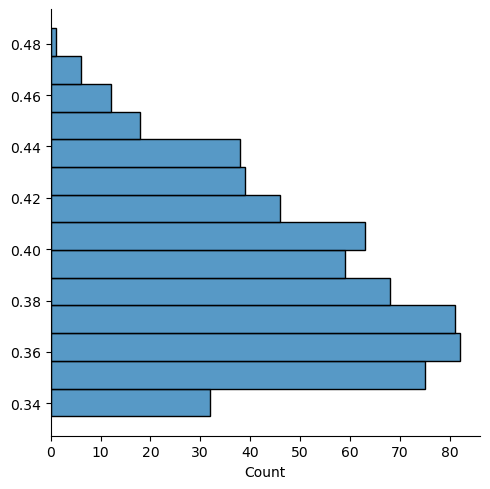

In [7]:
import matplotlib.pyplot as plt
import seaborn

seaborn.displot(y=predict_probability.detach().numpy()
                )

plt.show()

In [8]:
df_test.columns

Index(['Dates', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'USDJPYV1W Curncy',
       'USDJPYV1M Curncy', 'USDJPYV1Y Curncy', 'USDJPYVON Curncy',
       'JPYON Curncy', 'JPY1M Curncy', 'JPY12M Curncy', 'DXY Curncy',
       'GOLDS Comdty', 'CL1 Comdty', 'FEDL01 Index', 'USGG2YR Index',
       'USGG10YR Index', 'USGG30YR Index', 'GJGB2 Index', 'GJGB10 Index',
       'GJGB30 Index', 'SPX Index', 'VIX Index', 'NKY Index', 'Last_Return',
       'Predict_Return', 'SMA_10', 'EMA_5_100', 'RSI_5', 'RSI_22', 'RSI_100',
       'MACD_26_12', 'MACD_12_5', 'MACD_42_18', 'ROC_5',
       'Bollinger_Bands_lower_12', 'Bollinger_Bands_lower_100',
       'Bollinger_Bands_upper_12', 'Bollinger_Bands_upper_100', 'CCI_5',
       'CCI_22', 'CCI_100', '2Y spread', '10Y spread', '30Y spread'],
      dtype='object')

In [9]:
df_test.reset_index(inplace=True,drop=True)
df_test_result = df_test.loc[(time_delta-1):,['Dates','Predict_Return','JPYON Curncy']].copy()

df_test_result.rename(columns={'Predict_Return':'Real_Return'},inplace=True)
df_test_result.rename(columns={'JPYON Curncy':'carry return'},inplace=True)
df_test_result['carry return'] = - df_test_result['carry return']/10000  # add "-" because use USD/JPY ! 

df_test_result.rename(columns={'Predict_Return':'Real_Return'},inplace=True)

df_test_result

,Dates,Real_Return,carry return
21,2022-03-07,0.003035,0.000005
22,2022-03-08,0.001383,0.000005
23,2022-03-09,0.002676,0.000004
24,2022-03-10,0.009902,0.000009
25,2022-03-11,0.007673,0.000026
...,...,...,...
636,2024-07-15,0.001835,0.000245
637,2024-07-16,-0.013578,0.000236
638,2024-07-17,0.007490,0.000234
639,2024-07-18,0.000699,0.000234


In [10]:
columns_list = ["predict_down_rate","predict_fluct_rate","predict_up_rate"]

for i in range(len(columns_list)):
    df_test_result[columns_list[i]] = predict_raw_probability[:,i].detach().numpy()
    
df_test_result.set_index("Dates",drop=True,inplace=True)
    
    
df_test_result

,Real_Return,carry return,predict_down_rate,predict_fluct_rate,predict_up_rate
Dates,,,,,
2022-03-07,0.003035,0.000005,0.285693,0.382525,0.331782
2022-03-08,0.001383,0.000005,0.276817,0.403499,0.319684
2022-03-09,0.002676,0.000004,0.269586,0.421504,0.308911
2022-03-10,0.009902,0.000009,0.266129,0.437762,0.296109
2022-03-11,0.007673,0.000026,0.260035,0.458739,0.281226
...,...,...,...,...,...
2024-07-15,0.001835,0.000245,0.314658,0.379682,0.305660
2024-07-16,-0.013578,0.000236,0.319040,0.358036,0.322924
2024-07-17,0.007490,0.000234,0.323562,0.346964,0.329474


In [11]:
# act just as predict result

df_test_result["predict_action"] = np.where(predict_results.detach().numpy()==0,"short",
                                            np.where(predict_results.detach().numpy()==2,"long","no_act"))

df_test_result["pnl_change"] = np.where(predict_results.detach().numpy()==2,
                                        ((df_test_result["Real_Return"]+df_test_result['carry return'])-2/10000)
                                        .to_numpy(),
                                        np.where(predict_results.detach().numpy()==0,
                                                 (-((df_test_result["Real_Return"]+df_test_result['carry return'])-2/10000)
                                                                                       .to_numpy()),0))

df_test_result["pnl"] = df_test_result["pnl_change"].cumsum()

df_test_result

,Real_Return,carry return,predict_down_rate,predict_fluct_rate,predict_up_rate,predict_action,pnl_change,pnl
Dates,,,,,,,,
2022-03-07,0.003035,0.000005,0.285693,0.382525,0.331782,no_act,0.0,0.000000
2022-03-08,0.001383,0.000005,0.276817,0.403499,0.319684,no_act,0.0,0.000000
2022-03-09,0.002676,0.000004,0.269586,0.421504,0.308911,no_act,0.0,0.000000
2022-03-10,0.009902,0.000009,0.266129,0.437762,0.296109,no_act,0.0,0.000000
2022-03-11,0.007673,0.000026,0.260035,0.458739,0.281226,no_act,0.0,0.000000
...,...,...,...,...,...,...,...,...
2024-07-15,0.001835,0.000245,0.314658,0.379682,0.305660,no_act,0.0,0.182012
2024-07-16,-0.013578,0.000236,0.319040,0.358036,0.322924,no_act,0.0,0.182012
2024-07-17,0.007490,0.000234,0.323562,0.346964,0.329474,no_act,0.0,0.182012


In [12]:
action_signal = (np.max(predict_raw_probability.detach().numpy(),axis=-1)>act_threshold_rate) & (
    predict_results.detach().numpy() !=1 )

df_test_result["strategy_action"] =  np.where(~action_signal,"no_act",
                                            np.where(predict_results.detach().numpy()==2,"long","short"))

df_test_result

,Real_Return,carry return,predict_down_rate,predict_fluct_rate,predict_up_rate,predict_action,pnl_change,pnl,strategy_action
Dates,,,,,,,,,
2022-03-07,0.003035,0.000005,0.285693,0.382525,0.331782,no_act,0.0,0.000000,no_act
2022-03-08,0.001383,0.000005,0.276817,0.403499,0.319684,no_act,0.0,0.000000,no_act
2022-03-09,0.002676,0.000004,0.269586,0.421504,0.308911,no_act,0.0,0.000000,no_act
2022-03-10,0.009902,0.000009,0.266129,0.437762,0.296109,no_act,0.0,0.000000,no_act
2022-03-11,0.007673,0.000026,0.260035,0.458739,0.281226,no_act,0.0,0.000000,no_act
...,...,...,...,...,...,...,...,...,...
2024-07-15,0.001835,0.000245,0.314658,0.379682,0.305660,no_act,0.0,0.182012,no_act
2024-07-16,-0.013578,0.000236,0.319040,0.358036,0.322924,no_act,0.0,0.182012,no_act
2024-07-17,0.007490,0.000234,0.323562,0.346964,0.329474,no_act,0.0,0.182012,no_act


In [13]:
df_test_result["pnl_strategy_change"] = np.where(df_test_result["strategy_action"].to_numpy()=="long",
                                                 ((df_test_result["Real_Return"]+df_test_result['carry return'])-2/10000).to_numpy(),
                                        np.where(df_test_result["strategy_action"].to_numpy()=="short",
                                                 -(((df_test_result["Real_Return"]+df_test_result['carry return'])-2/10000).to_numpy()),0))

df_test_result["pnl_strategy"] = df_test_result["pnl_strategy_change"].cumsum()

df_test_result

,Real_Return,carry return,predict_down_rate,predict_fluct_rate,predict_up_rate,predict_action,pnl_change,pnl,strategy_action,pnl_strategy_change,pnl_strategy
Dates,,,,,,,,,,,
2022-03-07,0.003035,0.000005,0.285693,0.382525,0.331782,no_act,0.0,0.000000,no_act,0.0,0.000000
2022-03-08,0.001383,0.000005,0.276817,0.403499,0.319684,no_act,0.0,0.000000,no_act,0.0,0.000000
2022-03-09,0.002676,0.000004,0.269586,0.421504,0.308911,no_act,0.0,0.000000,no_act,0.0,0.000000
2022-03-10,0.009902,0.000009,0.266129,0.437762,0.296109,no_act,0.0,0.000000,no_act,0.0,0.000000
2022-03-11,0.007673,0.000026,0.260035,0.458739,0.281226,no_act,0.0,0.000000,no_act,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-15,0.001835,0.000245,0.314658,0.379682,0.305660,no_act,0.0,0.182012,no_act,0.0,0.221676
2024-07-16,-0.013578,0.000236,0.319040,0.358036,0.322924,no_act,0.0,0.182012,no_act,0.0,0.221676
2024-07-17,0.007490,0.000234,0.323562,0.346964,0.329474,no_act,0.0,0.182012,no_act,0.0,0.221676


/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


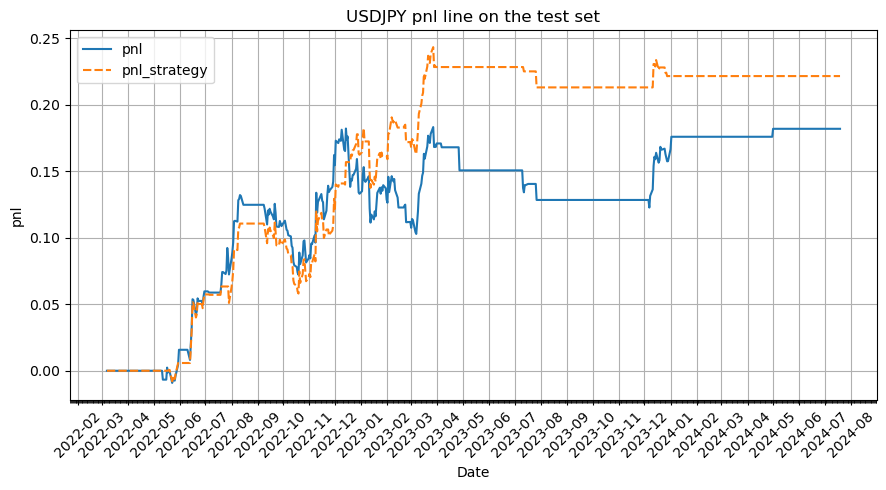

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Plot the DataFrame
plt.figure(figsize=(9, 5))  # Set the figure size
sns.lineplot(data=df_test_result[["pnl","pnl_strategy"]])

# Set major ticks format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set major ticks to every month


# Optionally, set minor ticks format
plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))  # Set minor ticks to every day

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('pnl')
plt.title('USDJPY pnl line on the test set')

# Show grid
plt.grid(True)

# Adjust layout to fit everything
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
df_test_result.iloc[-50:,:]

,Real_Return,carry return,predict_down_rate,predict_fluct_rate,predict_up_rate,predict_action,pnl_change,pnl,strategy_action,pnl_strategy_change,pnl_strategy
Dates,,,,,,,,,,,
2024-05-13,0.001280,0.000236,0.311846,0.394293,0.293861,no_act,0.0,0.182012,no_act,0.0,0.221676
2024-05-14,-0.009845,0.000232,0.321552,0.386712,0.291735,no_act,0.0,0.182012,no_act,0.0,0.221676
2024-05-15,0.003293,0.000231,0.310773,0.378080,0.311147,no_act,0.0,0.182012,no_act,0.0,0.221676
2024-05-16,0.001673,0.000231,0.316402,0.377820,0.305779,no_act,0.0,0.182012,no_act,0.0,0.221676
2024-05-17,0.003919,0.000693,0.293895,0.409044,0.297061,no_act,0.0,0.182012,no_act,0.0,0.221676
2024-05-20,-0.000576,0.000230,0.303915,0.398517,0.297567,no_act,0.0,0.182012,no_act,0.0,0.221676
2024-05-21,0.004034,0.000228,0.302265,0.413543,0.284192,no_act,0.0,0.182012,no_act,0.0,0.221676
2024-05-22,0.000829,0.000232,0.307710,0.407733,0.284557,no_act,0.0,0.182012,no_act,0.0,0.221676
2024-05-23,0.000382,0.000230,0.308280,0.405612,0.286108,no_act,0.0,0.182012,no_act,0.0,0.221676
